In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

import ewstools
from sklearn.preprocessing import MinMaxScaler

In [46]:
# Data is of the shape (number of trajectories, number of samples, grid size)
in_dim = 5 + 1 # dimensionality of ODE + dimension of input parameter
out_dim = 5

data = np.load("clouds_noisy_brownian_100_traj_small_dt.npy")
extra_calibration_data = np.load("clouds_noisy_brownian_100_traj_small_dt_set2.npy")

tipping_point = 10.0 # time of tipping point -- data-dependent!

dt = 1.0 / 365 # years
dt_sec = dt * 3600 * 24 * 365 # seconds
T1 = 0.0 # years
T2 = 20.0 # years
data = data[:,:-1] # Make shape easier to divide
extra_calibration_data = extra_calibration_data[:,:-1]

num_traj = data.shape[0]
traj_len = data.shape[1]

train_trajectories = 50
data_test_trajectories = 50
test_trajectories = len(data) + len(extra_calibration_data) - train_trajectories

# Min-max scaling
data = np.reshape(data, (num_traj, traj_len, in_dim))

extra_calibration_data = np.reshape(extra_calibration_data, (-1, traj_len, in_dim))

# Train-test split
test = data[-data_test_trajectories:]
test = np.concatenate([extra_calibration_data, test], axis=0)

test = np.reshape(test, (test_trajectories, -1, in_dim))

num_test = 5
test = test[-num_test:]

# EWS analysis

In [149]:
coord = 4

time_series = test[0, :, coord]

t = np.linspace(T1, T2, test.shape[1])

In [150]:
# Find true tipping point for this trajectory -- when cloud cover crosses 0.6
cf_critical_val = 0.6
true_tipping_point = T1

traj_cloud_cover = test[0, :, 4]

for i in range(len(traj_cloud_cover) - 1):
    if traj_cloud_cover[i] > cf_critical_val and traj_cloud_cover[i+1] < cf_critical_val:
        true_tipping_point += (2 * i + 1) / 2 * dt
        break

In [151]:
new_trans = (tipping_point - T1) / (T2 - T1) * test.shape[1]

ts = ewstools.TimeSeries(data=pd.Series(time_series), transition=new_trans)

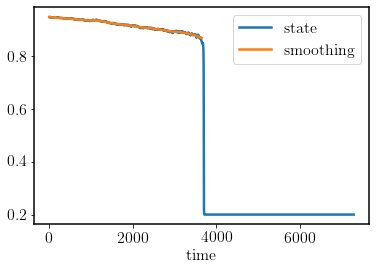

In [152]:
# Preprocess
ts.detrend(method='Lowess', span=0.1)
ts.state[['state','smoothing']].plot()
plt.show()

In [153]:
# Compute early-warning signals
rw = 0.25 # rolling window size
ts.compute_var(rolling_window=rw)
ts.compute_cv(rolling_window=rw)
ts.compute_auto(rolling_window=rw, lag=1)
ts.compute_skew(rolling_window=rw)

In [154]:
# Compute Kendall's tau
ts.compute_ktau()

# Plot results

In [127]:
fig = ts.make_plotly(kendall_tau=True)
fig.show()

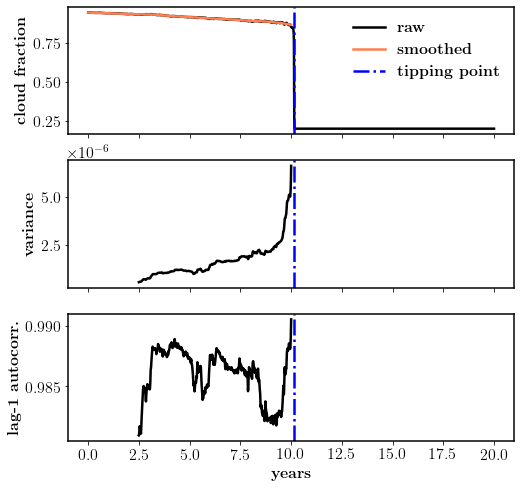

In [156]:
from matplotlib import rc

# Set LaTeX font rendering
rc('text', usetex=True)

# Set style parameters for a professional look
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 16
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['lines.linewidth'] = 2.5

coord_label = ['depth (m)', 'energy (J/kg)', 'total water specific humidity', 'sea surface temp. (K)', 'cloud fraction'][coord]
coord_label = r'\textbf{' + coord_label + '}'

fig1, axes = plt.subplots(nrows=3, ncols=1, figsize=(8,8), sharex=True)
axes[0].plot(t, ts.state[['state']], color='black', label=r'\textbf{raw}')
axes[0].plot(t, ts.state[['smoothing']], color='coral', label=r'\textbf{smoothed}')
axes[0].axvline(x=true_tipping_point, color='b', ls='-.', label=r'\textbf{tipping point}')
axes[0].set_ylabel(coord_label)

axes[1].plot(t, ts.ews['variance'], color='black')
axes[1].axvline(x=true_tipping_point, color='b', ls='-.')
axes[1].set_ylabel(r'\textbf{variance}')

axes[2].plot(t, ts.ews['ac1'], color='black')
axes[2].axvline(x=true_tipping_point, color='b', ls='-.')
axes[2].set_ylabel(r'\textbf{lag-1 autocorr.}')
axes[2].set_xlabel(r'\textbf{years}')

legend = axes[0].legend(loc='best', frameon=False)
legend.get_frame().set_linewidth(0)

plt.savefig("ews_coord5.pdf", format='pdf')
plt.show()